In [1]:
## import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner, plot_timeseries, scale_timeseries_data, \
filter_invalid_stocks, GenericModelRunner, GenericDataloader
print(torch.cuda.is_available())

# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


import torch
from torch import nn as nn
from torch.nn import functional as F

from transformer_common import GeluFeedForward, TransformerConfig, \
    PositionalEmbedding, DistancePositionalEmbedding, AbstractModel, RMSNorm,LinearFeedForward


class Block(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.l_norm1 = RMSNorm(config.n_embed)
        self.attention = attention_provider()
        self.l_norm2 = RMSNorm(config.n_embed)
        self.ffwd = GeluFeedForward(config.n_embed, config.hidden_size, config.n_embed, config.dropout, bias=False)

    def forward(self, x):
        x = x + self.attention(self.l_norm1(x))
        x = x + self.ffwd.forward(self.l_norm2(x))
        return x

class BlockSequence(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.blocks = nn.Sequential(*[Block(config, attention_provider) for _ in range(config.n_layer)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    
class TorchMultiHeadAttention(nn.Module):
    # https: // pytorch.org / docs / stable / generated / torch.nn.functional.scaled_dot_product_attention.html
    def __init__(self, config):
        super().__init__()

        num_heads = config.n_head
        embed_dimension = config.n_embed
        is_causal = config.causal
        dropout = config.dropout
        bias = False

        assert embed_dimension % num_heads == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(embed_dimension, 3 * embed_dimension, bias=bias)
        # output projection
        self.c_proj = nn.Linear(embed_dimension, embed_dimension, bias=bias)
        # regularization
        self.dropout = dropout
        self.resid_dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.embed_dimension = embed_dimension
        # Perform causal masking
        self.is_causal = is_causal

    def forward(self, x):
    
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        query_projected = self.c_attn(x)

        batch_size = query_projected.size(0)
        embed_dim = query_projected.size(2)
        head_dim = embed_dim // (self.num_heads * 3)

        query, key, value = query_projected.chunk(3, -1)
        query = query.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)

        # Apply attention with modified scores
        if self.training:
            dropout = self.dropout
            is_causal = self.is_causal
        else:
            dropout = 0.0
            is_causal = False

        y = F.scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=dropout,
                                           is_causal=is_causal)

        y = y.transpose(1, 2).view(batch_size, -1, self.num_heads * head_dim)

        y = self.resid_dropout(self.c_proj(y))
        return y


class TorchTransformerModel(AbstractModel):
    def __init__(self, config):
        super().__init__(config)
        # self.pos_emb1 = PositionalEmbedding(config)
        self.ffwd1 = GeluFeedForward(config.input_embed, config.hidden_size, config.n_embed, config.dropout, bias=True)
        self.t1 = BlockSequence(config, lambda: TorchMultiHeadAttention(config))
        self.ffwd2 = GeluFeedForward(config.n_embed, config.hidden_size, config.output_embed, config.dropout, bias=True)

    def forward(self, inp):
        x = inp
        b, t, c = x.shape
        x = self.ffwd1(x)
        # pos_emb = self.pos_emb1(b, t)
        x = self.t1(x)
        x = self.ffwd2(x)
        return x



False


In [2]:
import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
from transformer_common import TimeseriesDataloader

my_device = 'mps'

# Start the timer
start_time = time.time()

input_tensor_file = 'stock_history_data.pt'

if os.path.exists(input_tensor_file):
    data = torch.load(input_tensor_file)
    ln = len(data)
    print(f"Tensor loaded successfully: {input_tensor_file}, len={ln}")
else:
    directory_path = './us-stock-dataset/Data/StockHistory'

    all_files = [os.path.splitext(f)[0] for f in os.listdir(directory_path) if f.endswith('.csv')]
    
    stocks_to_load = set(all_files)
    dataloader = TimeseriesDataloader(directory_path, stocks_to_load, add_diff=False)
    
    data=dataloader.get_data().transpose(0, 1).cuda()

    torch.save(data, input_tensor_file)

    print(f"Tensor saved successfully: {input_tensor_file}")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")
# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


False
Tensor loaded successfully: stock_history_data.pt, len=6262
Execution time: 0.0216 seconds


/var/folders/3l/9k1jwyrx3nnfw4578m3876ww0000gn/T/ipykernel_1514/3072982693.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(input_tensor_file)


In [3]:
print(data.shape)

data = filter_invalid_stocks(data)
print(f"shape after filtering {data.shape}" )

torch.Size([6262, 5283])
shape after filtering torch.Size([4735, 5283])


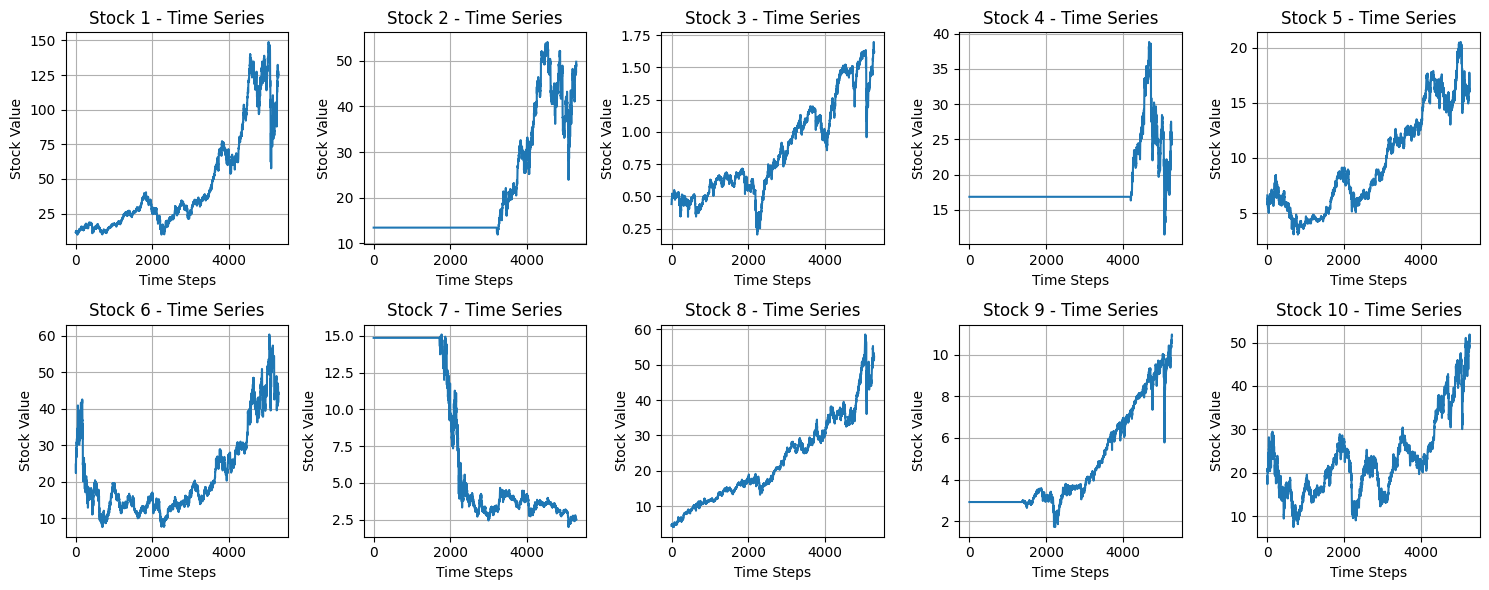

In [4]:
# Plotting the first 5 stocks' time-series data
plot_timeseries(data, num_charts=10)

In [5]:
# data = torch.diff(data, dim=1)
scaled_data = scale_timeseries_data(data, dim=1)  # Scale each stock independently
scaled_data.shape

torch.Size([4735, 5283])

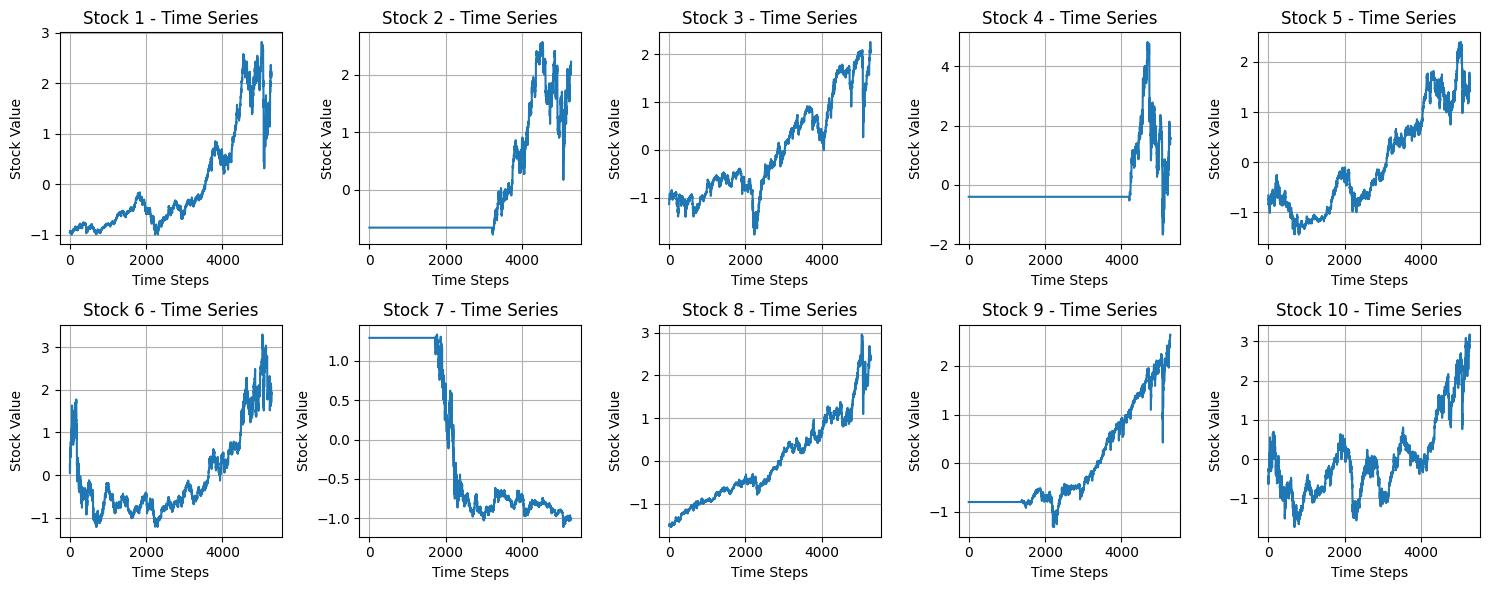

In [6]:
plot_timeseries(scaled_data, num_charts=10)

In [7]:
# data_diff = data.diff(dim=1)

In [8]:
data.shape

torch.Size([4735, 5283])

In [9]:
num_of_channels=128

back_window=32
pred_ahead=32
vocab_size=100

clean_data = scaled_data[0:num_of_channels,1:].transpose(0, 1)
print(clean_data.shape)

torch.Size([5282, 128])


In [10]:
inp_clean_data=clean_data[:-pred_ahead,:].unfold(dimension=0, size=back_window, step=1)
print(inp_clean_data.shape)
inp_clean_data=inp_clean_data.reshape(inp_clean_data.shape[0], -1)
inp_clean_data.shape

torch.Size([5219, 128, 32])


torch.Size([5219, 4096])

In [11]:
def create_diff_tensor(data: torch.Tensor, n: int, dim: int=2) -> torch.Tensor:
    """
    Creates a tensor of differences for predicting future time steps and applies sliding windows.

    Args:
        data (torch.Tensor): Input tensor of shape [stocks, time_steps].
        n (int): Number of future steps to compute differences for.
        chunk_size (int): Size of each sliding window.
        step (int, optional): Step size for sliding window. Defaults to 1.

    Returns:
        torch.Tensor: A tensor of shape [stocks, n, num_chunks, chunk_size], containing
                      sliding windows for day +1, day +2, ..., day +n.
    """
    stocks, time_steps = data.shape
    max_time_steps = time_steps - n  # Ensure consistent length across offsets

    diffs = []
    for offset in range(1, n + 1):
        # Compute differences trimmed to the max time dimension
        diff = data[:, offset:offset + max_time_steps] - data[:, :max_time_steps]

        diffs.append(diff)

    # Stack differences along a new dimension
    diff_tensor = torch.stack(diffs, dim=dim)  # [stocks, n, time_steps - n]

    # Apply sliding windows
    return diff_tensor
    
data_diff = create_diff_tensor(data, pred_ahead)

print(data_diff.shape)

data_diff = data_diff[0:num_of_channels, back_window:,:]
print(data_diff.shape)

torch.Size([4735, 5251, 32])
torch.Size([128, 5219, 32])


In [12]:
def to_long_buckets(t, vocab_size=100, width_in_std=1, dim=1):
    # Compute mean and std along the specified dimension, retaining dimensions for broadcasting
    std = t.std(dim=dim, keepdim=True)
    mean = t.mean(dim=dim, keepdim=True)

    # Normalize the tensor
    t = (t - mean) / std

    # Clip values to ±width_in_std
    t = t.clamp(min=-width_in_std, max=width_in_std)

    # Scale to vocab range and convert to long
    t = ((t + width_in_std) / (2 * width_in_std) * (vocab_size - 1)).long()

    return t

# Example usage
diff_longs = to_long_buckets(data_diff, vocab_size=vocab_size, width_in_std=2, dim=1).transpose(0, 1)
print(diff_longs.shape)


torch.Size([5219, 128, 32])


In [13]:
outp_clean_data = diff_longs.reshape(diff_longs.shape[0], -1)
print(outp_clean_data.shape)

torch.Size([5219, 4096])


In [14]:
outp_clean_data.shape

torch.Size([5219, 4096])

In [15]:
inp_clean_data.shape

torch.Size([5219, 4096])

In [16]:
back_window*num_of_channels

4096

In [17]:
pred_ahead*num_of_channels*vocab_size

409600

In [18]:
config = TransformerConfig(
    precision=torch.float32,
    batch_size=256,
    block_size=1,
    causal=True,
    input_embed=back_window*num_of_channels,
    n_embed=256,
    output_embed=pred_ahead*num_of_channels*vocab_size,
    n_head=4,
    n_layer=4,
    learning_rate=1e-4,
    shift_output=0,
    my_device=my_device,
    learning_type='classify'
)
config.eval_interval=500
config.save_model_periodically_every_n_iterations = -1

inp_clean_data, outp_clean_data = inp_clean_data.to(my_device), outp_clean_data.to(my_device)

trainer1 = GenericModelRunner(
    config, 
    TorchTransformerModel(config), 
    GenericDataloader(config, inp_clean_data, outp_clean_data)
) 

# trainer1.load_model('abc')

trainer1.train_iterate_n(20000)

trainer1.save_model('classify')

Using device: mps
427.709696 M parameters
step 0: rmse train loss 2.1494, rmse val loss 2.1507, sec/iter 4.291534423828125e-09
step 500: rmse train loss 1.5010, rmse val loss 2.3947, sec/iter 0.25076650381088256
step 1000: rmse train loss 1.4270, rmse val loss 3.2107, sec/iter 0.3562023100852966
step 1500: rmse train loss 1.3657, rmse val loss 3.7821, sec/iter 0.32997955989837646
step 2000: rmse train loss 1.3216, rmse val loss 4.1503, sec/iter 0.27393015813827515


KeyboardInterrupt: 

In [19]:
outp_clean_data.shape

torch.Size([5219, 4096])

In [20]:
sh=0

context = inp_clean_data[sh:1+sh, :]
context = context.reshape((1, context.shape[0], context.shape[1]))
print(context.shape)

out = trainer1.gen(context)
print(out.shape)

out = out.reshape(outp_clean_data.shape[-1], -1)
print(out.shape)

# inpa = context[0,:,0:pred_ahead]
# outpa = out[0,:,0:pred_ahead]

# to_plot = torch.cat([inpa, outpa], dim=1)
# plot_timeseries(to_plot, num_charts=1)

torch.Size([1, 1, 4096])
torch.Size([1, 1, 409600])
torch.Size([4096, 100])


In [21]:
num_of_channels

128

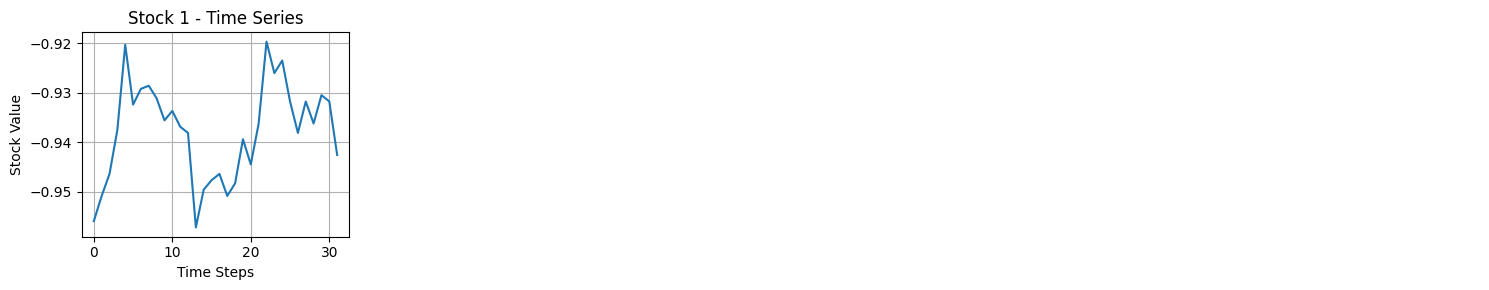

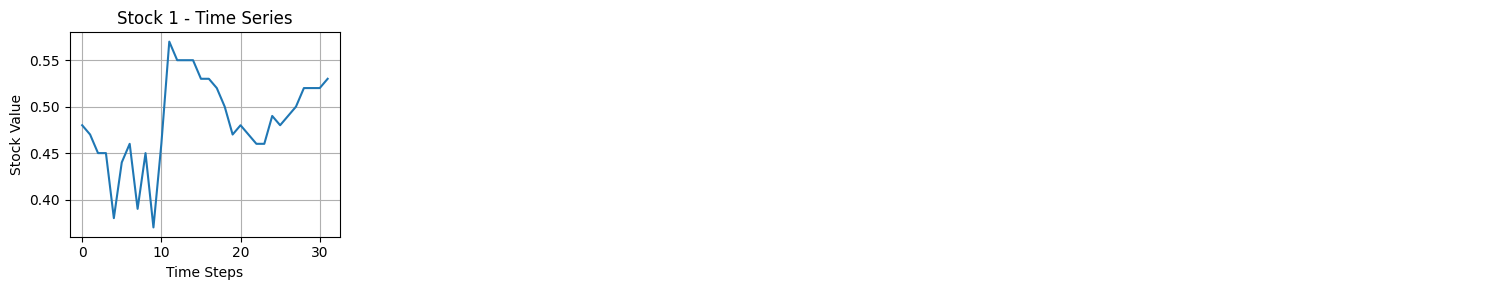

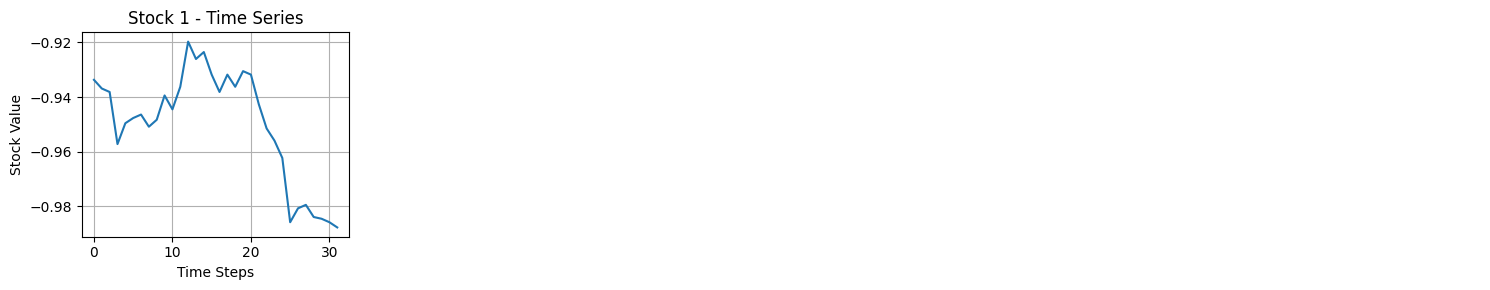

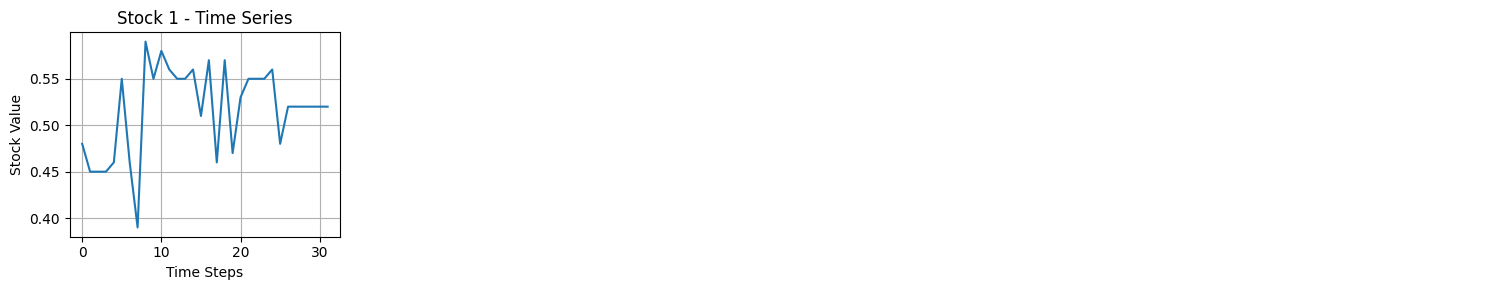

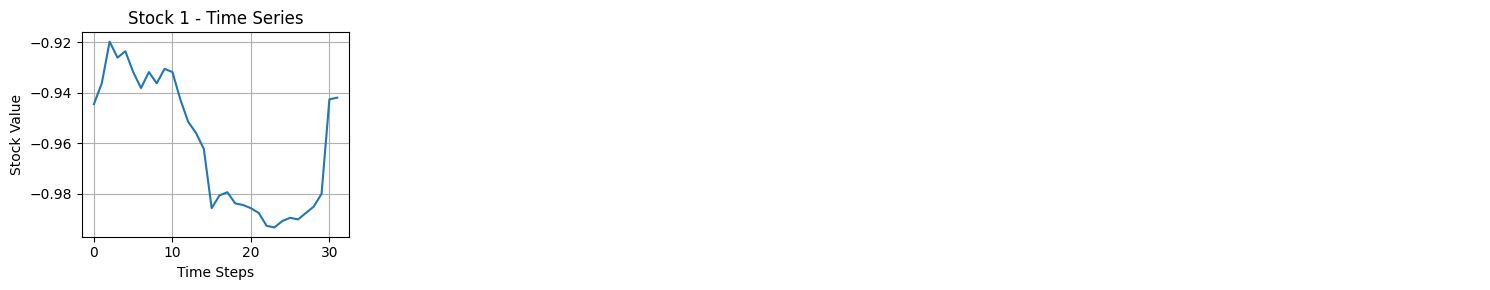

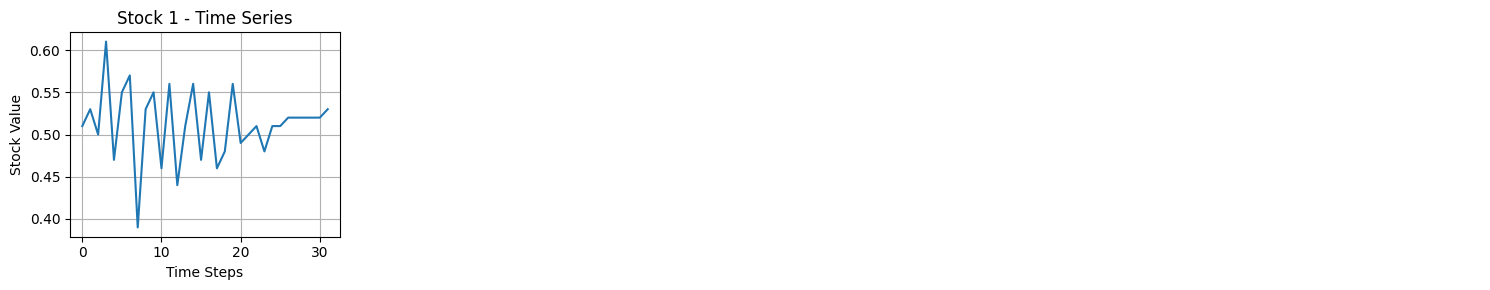

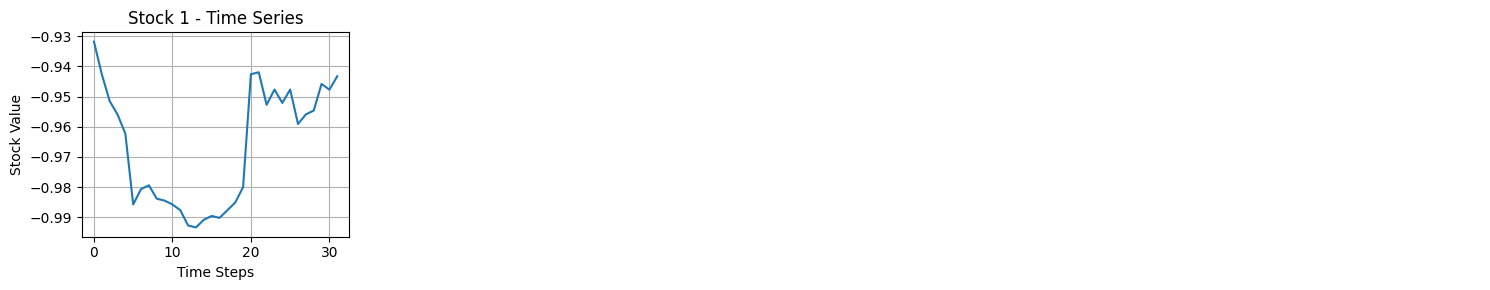

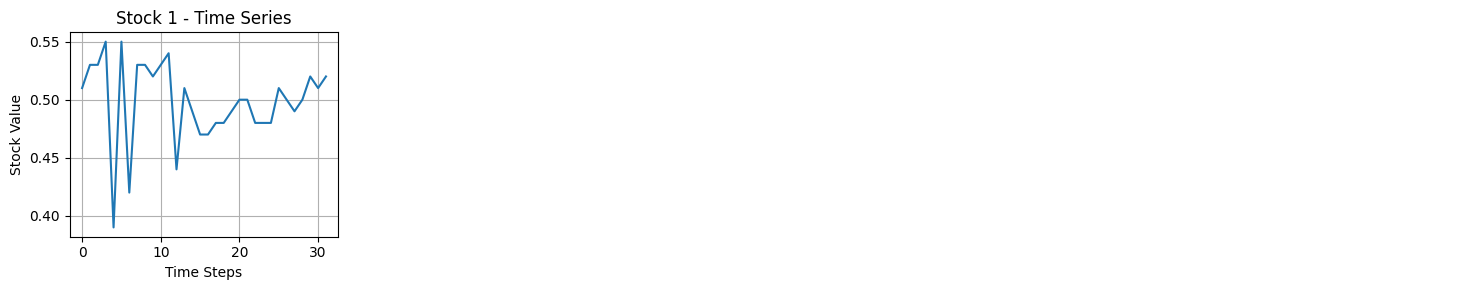

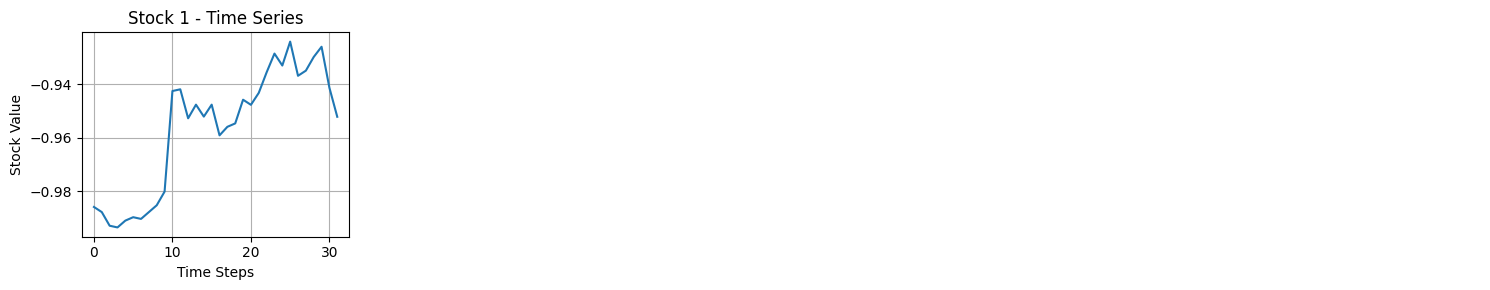

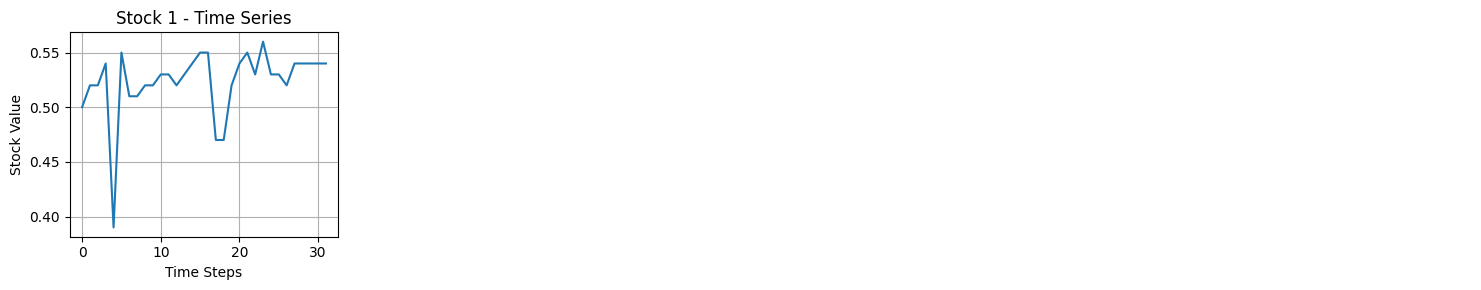

In [22]:
for i in range(0, 5):
    sh = 10 * i
    stock = 0

    stock_shift = stock * pred_ahead
    
    context = inp_clean_data[sh:1+sh, :]
    context = context.reshape((1, context.shape[0], context.shape[1]))
    # print(context.shape)
    
    out = trainer1.gen(context)
    # print(out.shape)

    inpa = context.view(1, num_of_channels, back_window)[:,stock,:]
    # inpa = context[0,:,0 + stock_shift:pred_ahead + stock_shift]
    plot_timeseries(inpa, num_charts=1)

    outp = out.view(1, num_of_channels, pred_ahead, -1)
    

    outp=torch.argmax(outp, dim=-1) / vocab_size
    
    plot_timeseries(outp[:,stock,:] , num_charts=1)
    
    # to_plot = torch.cat([inpa, outpa], dim=1)
    # plot_timeseries(to_plot, num_charts=1)

In [ ]:
import torch

# Example tensor: [4735 stocks, 5283 time steps]
stocks = 1
time_steps = 6
data = torch.randn(stocks, time_steps)  # Random data for example


In [ ]:
create_diff_tensor(data, 2)

In [ ]:
data